# NIH Chest X-Ray Dataset

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

all_xray_df = pd.read_csv('./archive/Data_Entry_2017.csv')
os.getcwd()
all_image_paths = {os.path.basename(x):x for x in glob(os.path.join('./archive', 'images*', '*', '*.png'))}
print(len(all_image_paths))
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
40318,00010504_001.png,No Finding,1,10504,45,M,PA,2992,2991,0.143,0.143,NaN,./archive\images_005\images\00010504_001.png
68683,00016954_005.png,No Finding,5,16954,33,M,AP,2500,2048,0.168,0.168,NaN,./archive\images_008\images\00016954_005.png
81061,00019911_004.png,Nodule,4,19911,51,M,PA,2992,2991,0.143,0.143,NaN,./archive\images_009\images\00019911_004.png


# Preprocessing Labels

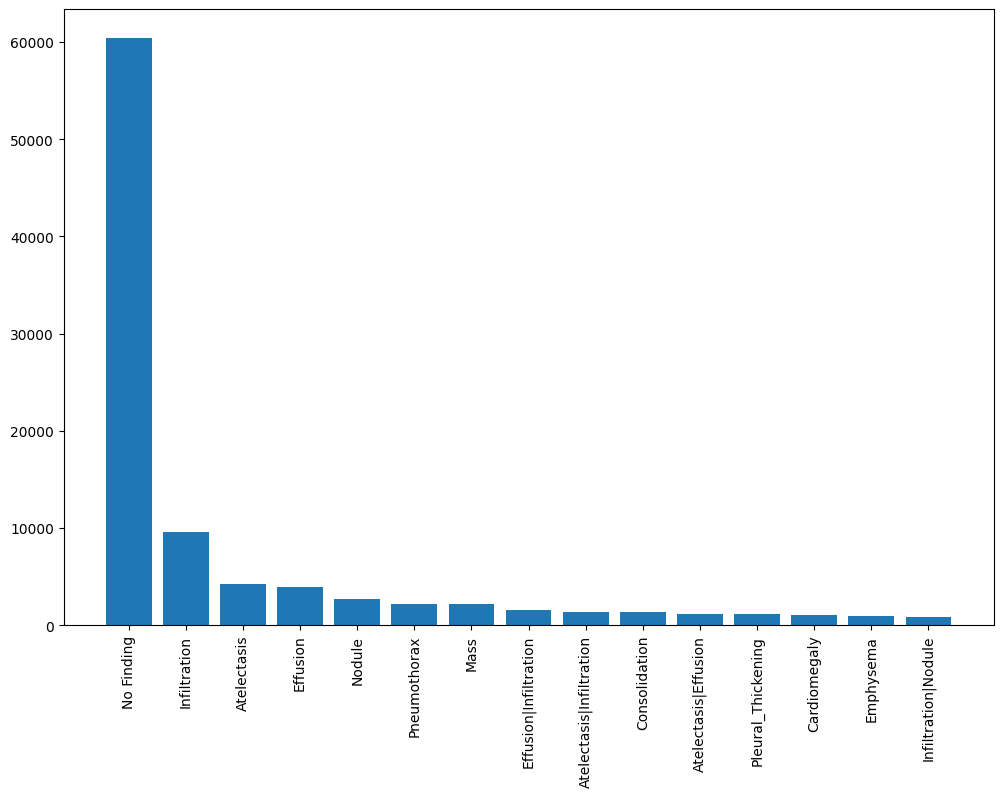

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12,8))
ax1.bar(np.arange(len(label_counts)),label_counts)
ax1.set_xticks(np.arange(len(label_counts)))
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x:x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x:x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda x: 1 if c_label in x else 0)
all_xray_df.sample(3)
len(all_labels)

14

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
69440,00017137_005.png,Atelectasis|Infiltration|Pneumothorax,5,17137,48,F,PA,2946,2948,0.143,...,0,0,0,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]"
10093,00002622_003.png,,3,2622,53,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
23359,00006194_001.png,,1,6194,34,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Resampling Weight

In [ ]:
from sklearn.model_selection import train_test_split
sample_weights = all_xray_df['Finding Labels'].map(lambda x : len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights = sample_weights/sample_weights.sum()
all_xray_df = all_xray_df.sample(10000, weights=sample_weights)

# Prepare Training Data

In [ ]:
train_df, valid_df = train_test_split(all_xray_df, test_size=0.25, random_state=2018, stratify=all_xray_df['Finding Labels'].map(lambda x: x[:4]))
valid_df, test_df = train_test_split(valid_df, test_size=0.25, random_state=2018, stratify=valid_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test',test_df.shape[0])

train 7500 validation 1875 test 625


In [ ]:
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df['newLabel'].apply(lambda x: [item for item in x if item in all_labels])
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['newLabel'] = valid_df['newLabel'].apply(lambda x: [item for item in x if item in all_labels])
test_df['newLabel'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['newLabel'] = test_df['newLabel'].apply(lambda x: [item for item in x if item in all_labels])
train_df[train_df['Finding Labels'].apply(lambda x: 'Hernia' in x)].sample(5)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec,newLabel
36029,00009507_012.png,Hernia|Infiltration,12,9507,60,M,AP,2500,2048,0.168,...,0,1,1,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]","[Hernia, Infiltration]"
88391,00021879_000.png,Fibrosis|Hernia|Infiltration,0,21879,67,M,PA,2992,2991,0.143,...,1,1,1,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]","[Fibrosis, Hernia, Infiltration]"
51064,00012905_000.png,Atelectasis|Hernia,0,12905,61,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[Atelectasis, Hernia]"
30734,00008010_000.png,Fibrosis|Hernia|Mass,0,8010,64,M,PA,2500,2048,0.168,...,1,1,0,1,0,0,0,0,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]","[Fibrosis, Hernia, Mass]"
63019,00015580_001.png,Cardiomegaly|Edema|Effusion|Fibrosis|Hernia,1,15580,78,F,PA,2992,2991,0.143,...,1,1,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]","[Cardiomegaly, Edema, Effusion, Fibrosis, Hernia]"


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = train_df['path'].iloc[0]
image = load_img(image_path)
image_array = img_to_array(image)

print(image_array.shape)

(1024, 1024, 3)


## Create Data Generators

In [ ]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)

train_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)
valid_idg = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
train_gen = train_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)
valid_gen = valid_idg.flow_from_dataframe(dataframe=valid_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 32)
test_gen = valid_idg.flow_from_dataframe(dataframe=test_df,
                             directory=None,
                             x_col = 'path',
                            y_col = all_labels,
                             class_mode = 'raw',
                            # classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 625)
test_X,test_Y = next(test_gen)


Found 7500 validated image filenames.
Found 1875 validated image filenames.
Found 625 validated image filenames.


(224, 224, 3)

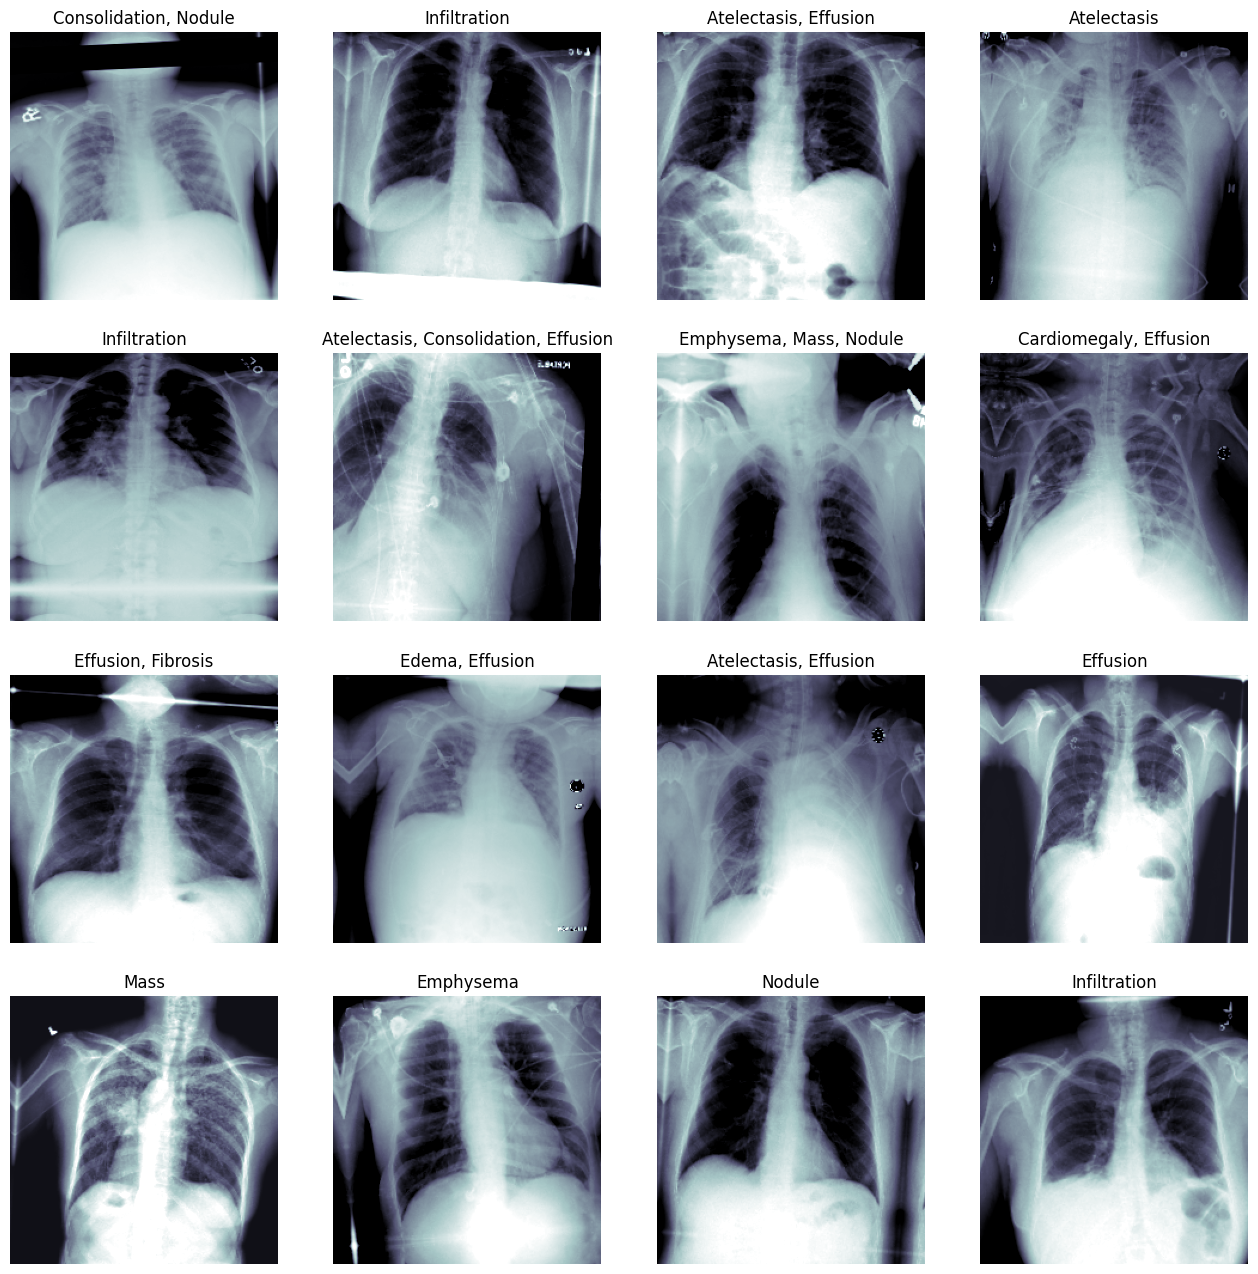

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4,4, figsize = (16,16))
for (c_x,c_y,c_ax) in zip(t_x,t_y,m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score>0.5]))
    c_ax.axis('off')
t_x.shape[1:]

# Model Development

##DenseNet121 with ChexNet weight

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Conv2D, Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras import regularizers

input_shape = t_x.shape[1:]
input_tensor = Input(shape=input_shape)

chexnet_weights = 'best_weights.h5'

base_model = DenseNet121(
    include_top=False,
    input_tensor=input_tensor,
    input_shape=input_shape,
    weights=None,
    pooling='avg'
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Dropout(0.3)(x)
predictions = Dense(len(all_labels), activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)  #添加正则化

model = Model(inputs=input_tensor, outputs=predictions)

model.load_weights(chexnet_weights)

for layer in model.layers[:-1]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy','mae']
)

model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
weight_path = "{}_.weights.h5".format('xray_class')
early = EarlyStopping(monitor='val_loss',mode='min',patience=5)
callbacks_list = [early, ModelCheckpoint(filepath=weight_path,monitor='val_loss',verbose=1,mode='min',save_best_only=True,save_weights_only=True)]

# Model Training and Evaluation

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8598 - loss: 0.3540 - mae: 0.1898
Epoch 1: val_loss improved from inf to 0.33645, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - binary_accuracy: 0.8598 - loss: 0.3540 - mae: 0.1898 - val_binary_accuracy: 0.8708 - val_loss: 0.3365 - val_mae: 0.1805
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8604 - loss: 0.3689 - mae: 0.1925
Epoch 2: val_loss improved from 0.33645 to 0.33443, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 226s 8s/step - binary_accuracy: 0.8603 - loss: 0.3690 - mae: 0.1925 - val_binary_accuracy: 0.8724 - val_loss: 0.3344 - val_mae: 0.1851
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8662 - loss: 0.3412 - mae: 0.1915
Epoch 3: val_loss improved from 0.33443 to 0.33007, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 231s 8s/step - binary_accuracy: 0.8662 - loss: 0.3414 - mae: 0.1914 

e:\codetool\Python\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss improved from 0.31751 to 0.31325, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - binary_accuracy: 0.8680 - loss: 0.3398 - mae: 0.1857 - val_binary_accuracy: 0.8784 - val_loss: 0.3132 - val_mae: 0.1770
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8711 - loss: 0.3361 - mae: 0.1867
Epoch 9: val_loss improved from 0.31325 to 0.31009, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - binary_accuracy: 0.8710 - loss: 0.3362 - mae: 0.1867 - val_binary_accuracy: 0.8780 - val_loss: 0.3101 - val_mae: 0.1804
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - binary_accuracy: 0.8660 - loss: 0.3395 - mae: 0.1909
Epoch 10: val_loss improved from 0.31009 to 0.30744, saving model to xray_class_.weights.h5
30/30 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - binary_accuracy: 0.8659 - loss: 0.3396 - mae: 0.1910 - val_binary_accuracy: 0.8782 - val_loss: 0.3074 - val_mae: 0.1785
Epoch 11/20
30/30 ━━━━━━━━━━━━

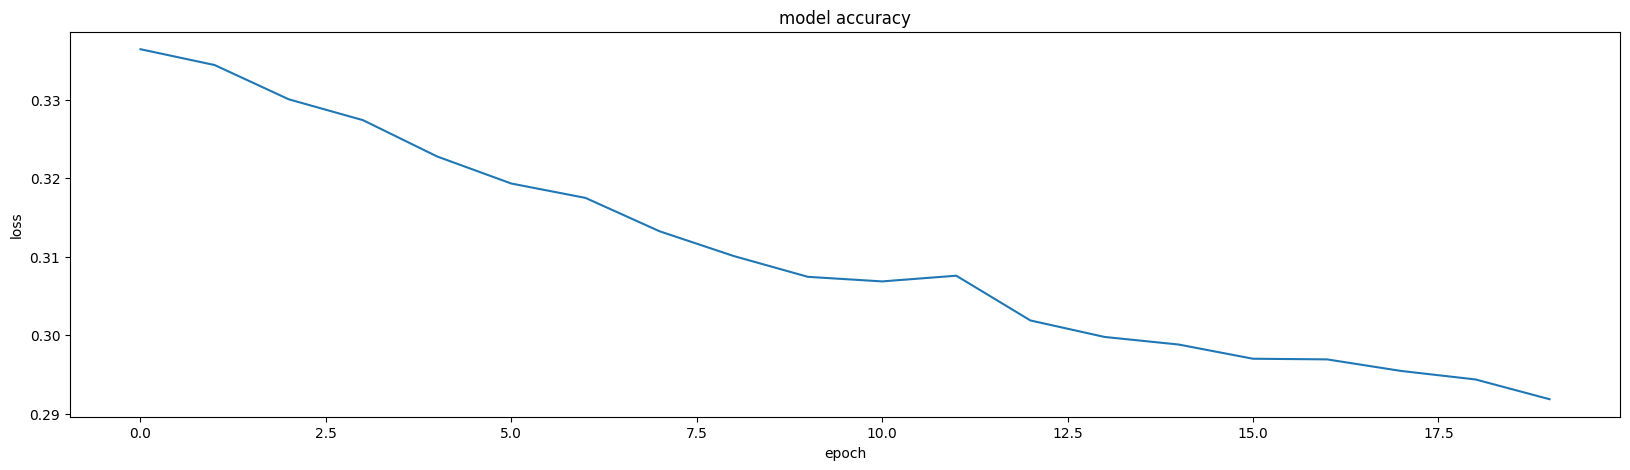

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,5))
tf.keras.backend.clear_session()
history = model.fit(train_gen,steps_per_epoch=30 ,validation_data=valid_gen, epochs=20, callbacks=callbacks_list, batch_size=256, validation_batch_size=1024)
plt.plot(history.history['val_loss'])

plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

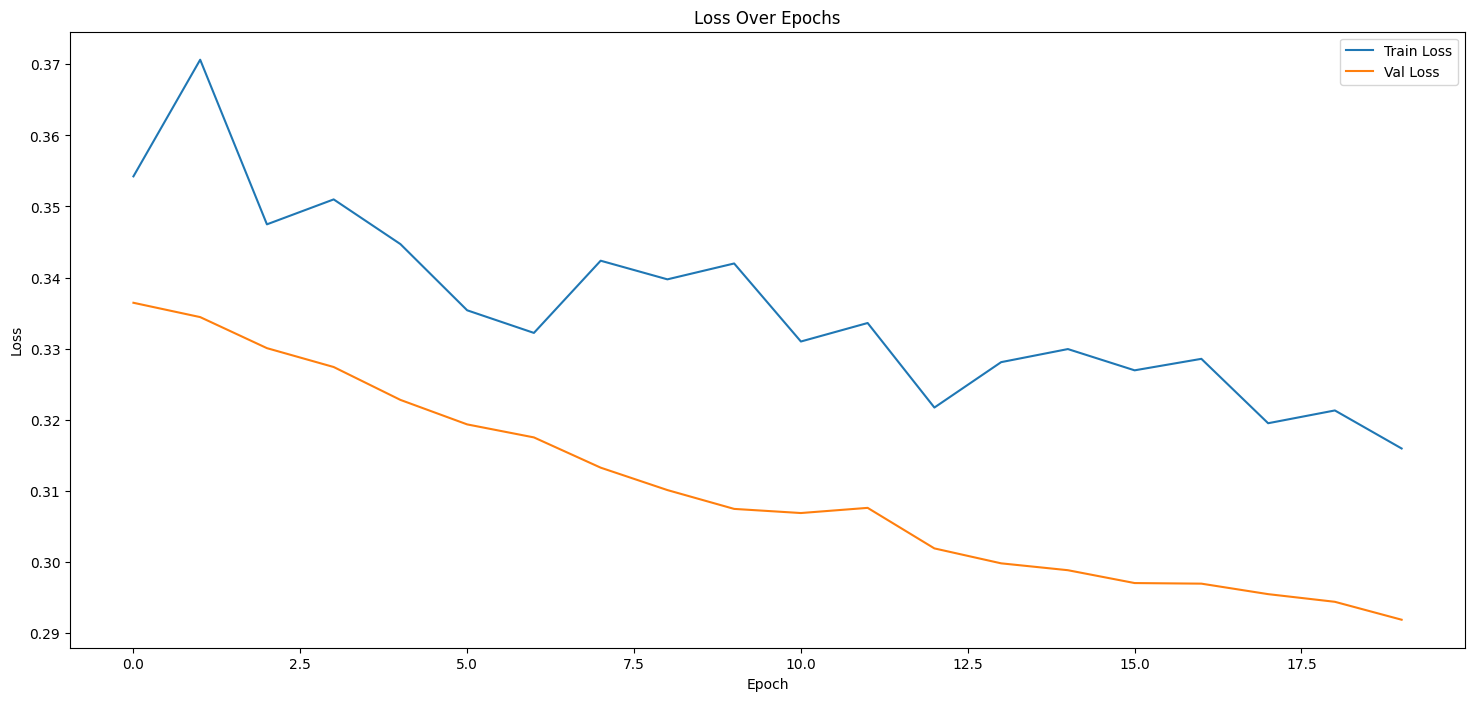

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Val Loss')

plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('optimizer_selection.png', bbox_inches='tight')

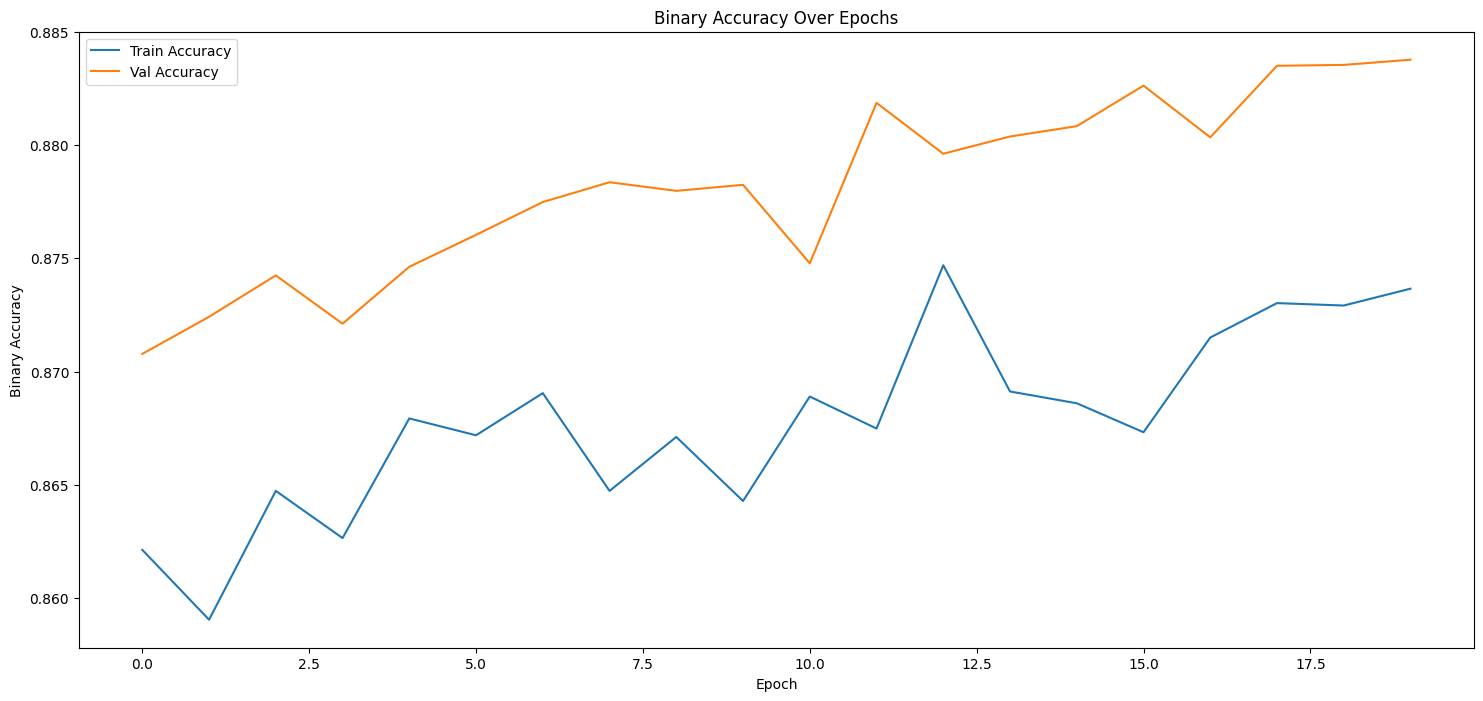

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(history.history['binary_accuracy'],label='Train Accuracy')
plt.plot(history.history['val_binary_accuracy'],label='Val Accuracy')

plt.title('Binary Accuracy Over Epochs')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

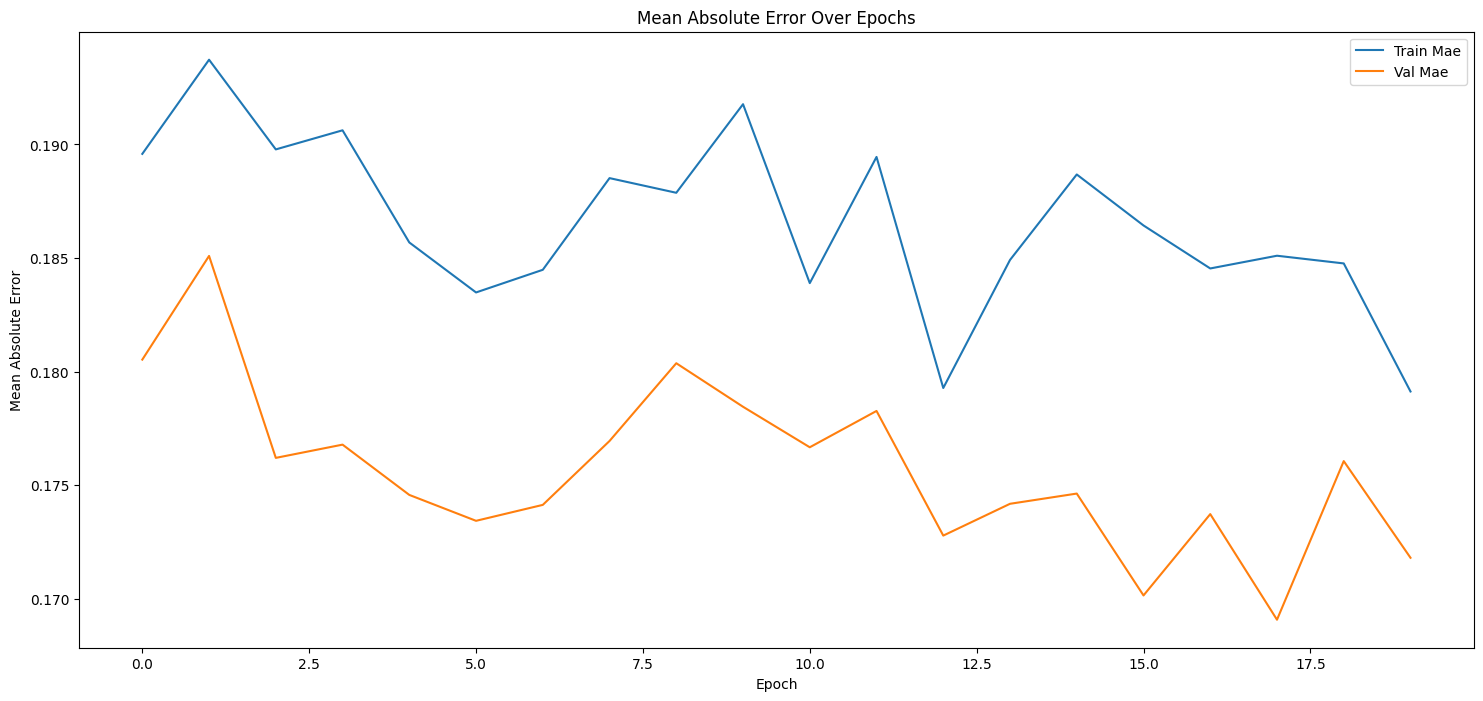

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(history.history['mae'],label='Train Mae')
plt.plot(history.history['val_mae'],label='Val Mae')

plt.title('Mean Absolute Error Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy, test_mae = model.evaluate(test_X, test_Y,verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test MAE: {test_mae}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - binary_accuracy: 0.8894 - loss: 0.2823 - mae: 0.1662
Test Loss: 0.2917381823062897
Test Accuracy: 0.8821713924407959
Test MAE: 0.17068906128406525


20/20 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step


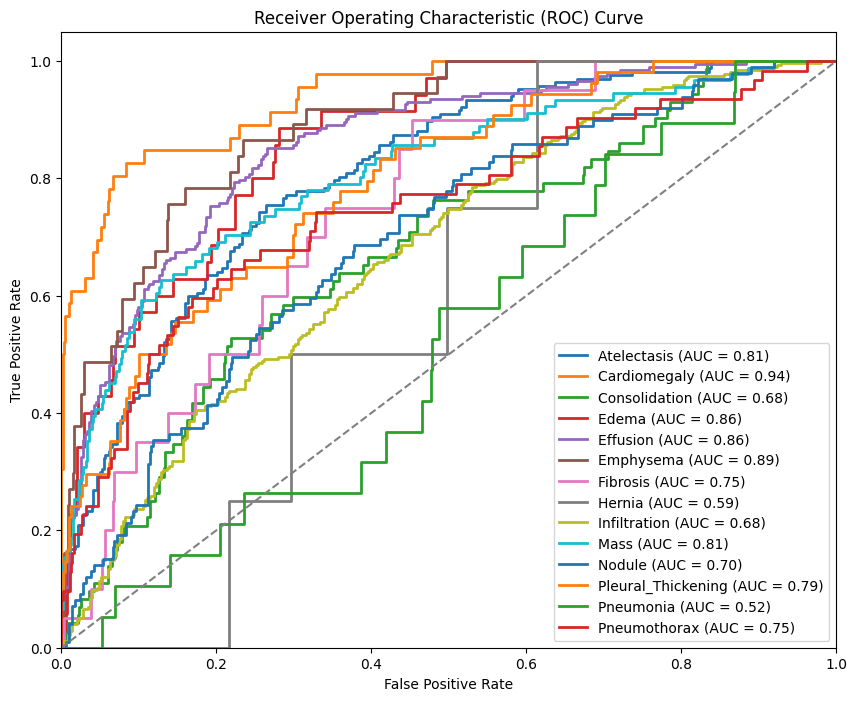

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probabilities = model.predict(test_X, verbose=1)

from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i in range(test_Y.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for i in range(test_Y.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{all_labels[i]} (AUC = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

plt.legend(loc="lower right", prop={'size': 10})

plt.show()


